In [1]:
import numpy
import json

from matplotlib import pyplot as plt
from scipy import sparse
from scipy.stats import hypergeom
from scipy import spatial

from bluepysnap import Circuit

In [2]:
circuit_path = '/home/tdelemon/1.Workdir/tests/mooc-106/circuit/circuit_config.json'
circuit = Circuit(circuit_path)
cells = circuit.nodes["hippocampus_neurons"]
conn = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical"]

In the first part of this exercise, we found that neurons in a local circuit tend to have more (graph-theoretical) "common neighbors" than expected, even when compared to a powerful control case. But Perin et al., 2011 found also another trend: Neuron pairs with many common neighbors are more likely to be connected to each other than pairs with few. In other words, the connection probability depends on the number of common neighbors of a pair.
![CN2.PNG](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2.png)

And as before, we will see if we can find this tendency in an in-silico hippocampal microcircuit. Once more, we want analyze this tendency on a much more global scale than sampling 8 neurons at a time. So to start we define the functions to generate the full efferent connectivity of a population and to calculate the matrix of common neighbor numbers from it, as before (see "Common neighbor analysis 1").

In [3]:
def efferent_con_mat(pop_gids):
    '''Returns a sparse matrix of the EFFERENT connectivity of neurons in
    the specified population'''
    shape = (len(pop_gids), cells.size) # The output shape is (number of neurons in population x number of neurons in circuit)
    
    post = [conn.efferent_nodes(_g) for _g in pop_gids]  # Get identifiers of connected neurons
    '''prepare the sparse matrix representation, where the column indices for row i are stored in
    "indices[indptr[i]:indptr[i+1]]" and their corresponding values are stored in "data[indptr[i]:indptr[i+1]]".'''
    indptr = numpy.hstack((0, numpy.cumsum(list(map(len, post)))))
    indices = numpy.hstack(post)
    data = numpy.ones_like(indices, dtype=bool) # Simple boolean connection matrix. A connection exists or not.
    return sparse.csr_matrix((data, indices, indptr), shape=shape)


Now for this example, we will do something slightly different. As mentioned, we want to see whether the connection probability increases with the number of common neighbors. But because connectivity is directed, we can go one step further: We can also analyze how this increase depends on the direction of the connection.
![CN2b.PNG](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2b.png)

For this, we consider the number of common neighbors between two different populations, in the illustration above indicated by the blue star and the black circle. We can consider the number of commonn neighbors between pairs of neurons where one neuron is in the "star" population and the other in the "circle" population and then evaluate separately how this influences the connection probability from star to circle and from circle to star.

Here, we use the excitatory and inhibitory sub-populations.

In [4]:
analyze_population1 = 'Excitatory'
analyze_population2 = 'Inhibitory'

n_smpl_population = 2500
analyze_gids1 = cells.ids(analyze_population1, sample=n_smpl_population)
analyze_gids1.sort()

analyze_gids2 = cells.ids(analyze_population2)

connections1 = efferent_con_mat(analyze_gids1)
connections2 = efferent_con_mat(analyze_gids2)

print (connections1.shape, connections2.shape)

(2500, 18198) (1338, 18198)


Because we can calculate the number of common neighbors with a matrix multiplication, we have to change the code very little. Simply instead of multiplying a connection matrix with its transpose, we multiply one matrix with the transpose other. The result is a matrix of the number of common neighbors for all pairs of the two populations.

(2500, 1338)


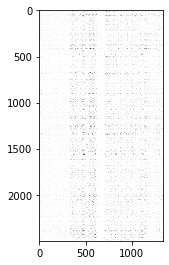

In [5]:
def common_efferent_neighbors(M, *args):
    if len(args) == 0: # No second matrix provided: Default to the early use case, com. neighs. within the population
        return common_efferent_neighbors(M, M)
    M2 = args[0]
    assert M.shape[1] == M2.shape[1]
    CN = M.astype(int) * M2.astype(int).transpose() # Our new use case: com. neighs. for pairs of the two populations
    return CN.toarray()

com_neighs = common_efferent_neighbors(connections1, connections2)
print(com_neighs.shape)
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.imshow(com_neighs, cmap='Greys');

Unlike earlier, this matrix is no longer symmetrical and it does not have the large entries along the main diagonal. This is because the two populations are disjunct, so we never evaluate the number of common neighbors between a neuron and itself.

Next, we need the connectivity between the two defined populations. Luckily, we already have the connectivity from population1 to everything (and also from population2 to everything), so we can get the required connection matrices as a sub-matrices of that. We will get two such matrices, one each for the analysis of increased connection probability in either direction.

In [6]:
con_1_to_2 = connections1[:, analyze_gids2] # minus 1 because neuron gids start counting at 0.
con_2_to_1 = connections2[:, analyze_gids1].transpose() # transpose because we need population 1 to be along the first axis.

With all of this, we can now plot how the connection probability in either direction depends on the number of common neighbors between pairs of neurons of the two populations. We define a minimum of 10 connections to be sampled to establish a proper probability.

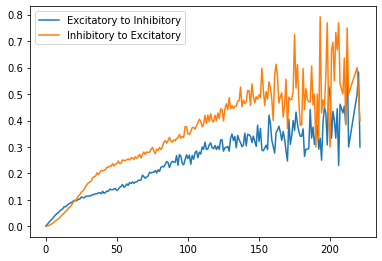

In [7]:
def con_prob_for_common_neighbors(cn_mat, connections, min_connections=10):
    cn_x = numpy.unique(cn_mat)
    smpls = [connections[cn_mat == i] for i in cn_x]
    result = [(x, y.mean()) for x, y in zip(cn_x, smpls)
              if numpy.prod(y.shape) >= min_connections]
    return zip(*result)

x1, y1 = con_prob_for_common_neighbors(com_neighs, con_1_to_2)
x2, y2 = con_prob_for_common_neighbors(com_neighs, con_2_to_1)
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x1, y1, label='%s to %s' % (analyze_population1, analyze_population2))
ax.plot(x2, y2, label='%s to %s' % (analyze_population2, analyze_population1))
ax.legend();

As we can see, the way the number of common neighbors affects the connection probability indeed does depend on the direction of the connection: for common neighbor numbers over 50 there is a much stronger increase for inhibitory to excitatory, but eventually both flatten out and no longer increase for common neighbors above 250.

As before, as an exercise, let's generalize to consider afferent common neighbors.
### Exercise 1: Calculate the connection probability dependent on the number of afferent common neighbors
#### 1a: What is the mean excitatory to inhibitory connection probability for such pairs with more than 75 afferent common neighbors?
assign the result to a variable ans_1a
#### 1b: What is the mean inhibitory to excitatory connection probability for such pairs with more than 75 afferent common neighbors?
assign the result to a variable ans_1b


In [8]:
# Work here

Now, with this analysis, we once again have to compare to a powerful control. Maintaining the distance dependence in the control is especially crucial this time: We know that the connection probability is much higher for neuron pairs close to each other. Consequently, a neuron that is connected to two other neurons, i.e. a common neighbor is likely to be close to both of them. That in turn is only possible if the two other neurons are close to each other as well, especially if there are many common neighbors between them. This means that in any network with a higher connection probability for nearby neurons the connection probability depends on the number of common neighbors. But that is not the effect we want to measure. We want to know how much the connection probability is increased for many common neighbors ON TOP of that effect.
So we go directly for the control preserving the distance dependence.

-1 49 (2500, 18198)
-1 49 (1338, 18198)


/home/tdelemon/.virtualenvs/mooc/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


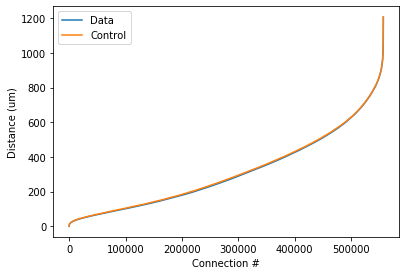

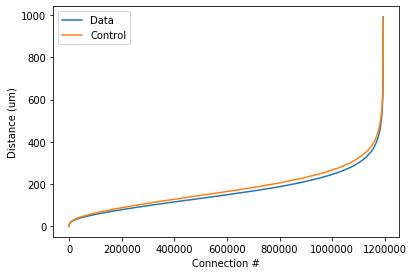

In [9]:
nbins = 50

def connect_keep_dist_dep(D, C, nbins):
    '''Randomly connect a number of neurons, keeping their distance dependence intact.
    D: Matrix (AxN) of distances to all other neurons in the circuit
    C: Matrix (AxN) of connections to all other neurons in the circuit (boolean)'''
    dbins = numpy.linspace(0, D.max(), nbins + 1) + 0.1
    Di = numpy.digitize(D, bins=dbins) - 1
    print(numpy.min(Di), numpy.max(Di), Di.shape)
    H_connected = numpy.histogram(Di[C.toarray()], bins=range(nbins + 1))[0]
    H_all = numpy.histogram(Di, bins=range(nbins + 1))[0]
    P = H_connected.astype(float) / H_all
    n_eff = numpy.array(C.sum(axis=1)).transpose()[0]
    indptr = [0]
    indices = []
    for row, n in zip(Di, n_eff):
        p_row = P[row]
        p_row[row == -1] = 0
        p_row = p_row / p_row.sum()
        rnd = numpy.random.choice(len(row), n, replace=False, p=p_row)
        indices.extend(rnd)
        indptr.append(indptr[-1] + n)
    data = numpy.ones_like(indices, dtype=bool)
    return sparse.csr_matrix((data, indices, indptr), shape=D.shape)

xyz = cells.positions()
# get distance matrix as an input
D1 = spatial.distance_matrix(xyz.loc[analyze_gids1], xyz)
D2 = spatial.distance_matrix(xyz.loc[analyze_gids2], xyz)

rnd_connections1 = connect_keep_dist_dep(D1, connections1, nbins)
rnd_connections2 = connect_keep_dist_dep(D2, connections2, nbins)

# compare distribution of distances of connected neurons
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(sorted(D1[connections1.toarray()]), label='Data')
ax.plot(sorted(D1[rnd_connections1.toarray()]), label='Control')
ax.legend(); ax.set_xlabel('Connection #'); ax.set_ylabel('Distance (um)')

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(sorted(D2[connections2.toarray()]), label='Data')
ax.plot(sorted(D2[rnd_connections2.toarray()]), label='Control')
ax.legend(); ax.set_xlabel('Connection #'); ax.set_ylabel('Distance (um)');

Now we analyze if and how the connection probability in the controls depends on the number of common neighbors.

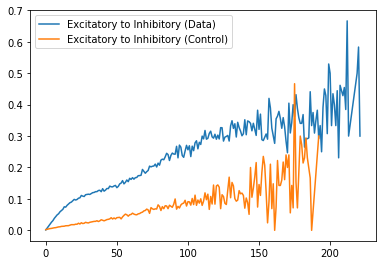

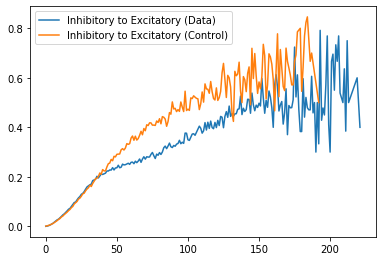

In [10]:
rnd_com_neighs = common_efferent_neighbors(rnd_connections1, rnd_connections2)
rnd_con_1_to_2 = rnd_connections1[:, analyze_gids2]
rnd_con_2_to_1 = rnd_connections2[:, analyze_gids1].transpose()
rnd_x1, rnd_y1 = con_prob_for_common_neighbors(rnd_com_neighs, rnd_con_1_to_2)
rnd_x2, rnd_y2 = con_prob_for_common_neighbors(rnd_com_neighs, rnd_con_2_to_1)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x1, y1, label='%s to %s (Data)' % (analyze_population1, analyze_population2))
ax.plot(rnd_x1, rnd_y1, label='%s to %s (Control)' % (analyze_population1, analyze_population2))
ax.legend()

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x2, y2, label='%s to %s (Data)' % (analyze_population2, analyze_population1))
ax.plot(rnd_x2, rnd_y2, label='%s to %s (Control)' % (analyze_population2, analyze_population1))
ax.legend();

We see that the bias for increased connectivity between neurons with many common neighbors is better explained by the control in one direction than the other. The effect on top of the one caused by distance dependence is much stronger from excitatory to inhibitory. In fact for the inhibitory to excitatory direction the control depicts a stronger increase than the data. Fascinating!

As before, let us define a metric that captures this tendency. This is inspired by the clustering coefficient, which is defined as the fraction of closed triangle motifs, where a triangle motif consists of a pair of neurons and a common neighbor and it is considered closed if the pair is connected as well.
![Sketch_CN2c.png](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2c.png)

Consequently, we count the number of common efferent neighbors of connected neurons (closed triangles) and divide it by the number of common efferent neighbors overall (all triangles). And we can do this analysis separately for the excitatory to inhibitory and inhibitory to excitatory directions.
![Sketch_CN2d.png](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2d.png)

The result is then normalized with respect to our strong control. For a proper analysis we should generate more than one control, but for this example we keep it at one.

Text(0, 0.5, 'Normalized CC')

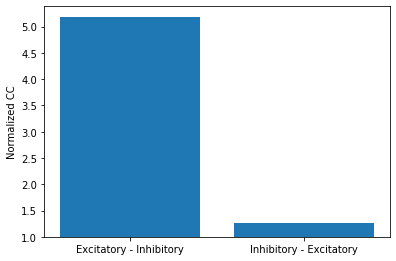

In [11]:
def cn_cluster_coefficient(cn_mat, connections):
    num_closed = cn_mat[connections.toarray()].sum()
    num_total = cn_mat.sum()
    return float(num_closed) / num_total

CC_1_to_2 = cn_cluster_coefficient(com_neighs, con_1_to_2)
CC_2_to_1 = cn_cluster_coefficient(com_neighs, con_2_to_1)
CC_1_to_2_nrmlz = CC_1_to_2 / cn_cluster_coefficient(rnd_com_neighs, rnd_con_1_to_2)
CC_2_to_1_nrmlz = CC_2_to_1 / cn_cluster_coefficient(rnd_com_neighs, rnd_con_2_to_1)

ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
'''For plotting, we let the bars start at a value of 1, since that
is the value indicating no effect (bottom=1). To compensate, we have
to subtract 1 from the height of the bars.'''
ax.bar([1, 2], [CC_1_to_2_nrmlz - 1, CC_2_to_1_nrmlz - 1], bottom=1)
ax.set_xticks([1, 2])
ax.set_xticklabels(["%s - %s" % lbl for lbl in [(analyze_population1, analyze_population2),
                                               (analyze_population2, analyze_population1)]])
ax.set_ylabel("Normalized CC")

Indeed the metric shows a stronger effect for the E to I direction than the other way around. In fact, the I to E effect is so weak, that it might not even be statistically significant. The interested reader is encouraged to generate more random instances and test whether the effect is statistically different from the control.

### Exercise 2: Calculate the normalized clustering coefficient for common afferent neighbors, i.e. when the following triangle motifs are considered

![Sketch_CN5.png](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2e.png)

#### 2a: What is the normalized clustering coefficient when above triangle motifs are considered in the excitatory to inhibitory direction?
Assign the result to a variable ans_2a
#### 2b: Same, for the inhibitory to excitatory direction
Assign the result to a variable ans_2b

In [12]:
# Work here

The result indicates a strong prevalence for the following type of motif:
![Sketch_CN3.png](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2f.png)

An excitatory and an inhibitory neuron have a common neighbor and the excitatory neuron is also connected to the inhibitory neuron. In other words: the excitatory neuron innervates a neuron directly and simultaneously inhibits it disynaptically!

Let's see if we can look at this in some other way. First, we can actually get a matrix of disynaptic inhibition from excitatory neurons with a simple matrix multiplication. Then we can see how much disynaptic inhibition is there for directly innervated neurons and overall.

Disynaptic inhibition of innervated neurons (data, control):  10.15584580951083 1.9197214470692043
Overall disynaptic inhibition (data, control):  2.7226442026596627 0.796778327288678


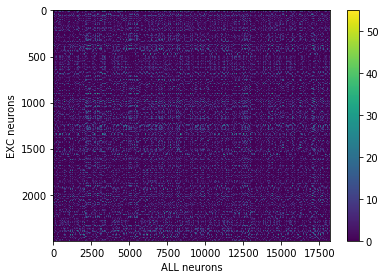

In [13]:
disynaptic = con_1_to_2.astype(int) * connections2.astype(int)
rnd_disynaptic = rnd_con_1_to_2.astype(int) * rnd_connections2.astype(int)
ax = plt.figure().add_axes([0.1, 0.1, 0.8, 0.8])
plt.colorbar(ax.imshow(disynaptic.toarray(), aspect='auto'))
ax.set_xlabel('ALL neurons'); ax.set_ylabel("EXC neurons")
print("Disynaptic inhibition of innervated neurons (data, control): ", disynaptic[connections1].mean(), rnd_disynaptic[rnd_connections1].mean())
print("Overall disynaptic inhibition (data, control): ", disynaptic.mean(), rnd_disynaptic.mean())

The result counts the number of inhibitory neurons mediating disynaptic inhibition from a given excitatory neuron onto another neuron. For example, if a neuron directly excites another neuron, it also disynaptically inhibits the neuron via a mean of 26 inhibitory neurons.

We confirm that simultaneous mono- and disynaptic inhibition motifs are overexpressed. First, there is 4 times more disynaptic inhibition in the data than control. Also, the disynaptic inhibition of innervated neurons is 4 times overexpressed in the data (26.36 / 6.60) and only 2.4 times in the control (3.28 / 1.36).

### Exercise 3: Compute the prevalence of disynaptic excitation
That is, for this exercise, we count the prevalence of the following motif:
![Sketch_CN6.png](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/CN2g.png)

#### 3a: What is the mean amount of disynaptic excitation onto neurons from a given excitatory neuron?
Analysis as above, but for a different type of motif. Assign the answer to a variable ans_3a

#### 3b: What is the mean amount of disynaptic excitation onto neurons that are also directly (monosynaptically) innervated?
Assign the answer to a variable ans_3b.



In [ ]:
# Work here

With just a handful of matrix multiplications and indexing operations we have predicted an interesting connectivity trend. And this was just focused on post-synaptic common neighbors. The interested reader is encouraged to try and test what this looks like for presynaptic common neighbors.

In [ ]:
# This is to generate the answers to paste in the submission box below.
# Run this and copy-paste the output into the box below
print(json.dumps(dict([("ans_1a", ans_1a),
                       ("ans_1b", ans_1b),
                       ("ans_2a", ans_2a),
                       ("ans_2b", ans_2b),
                       ("ans_3a", ans_3a),
                       ("ans_3b", ans_3b)])))

In [ ]:
!pip -q install -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client==0.0.5 
import single_cell_mooc_client as sc_mc
s = sc_mc.Submission(hideToken=True)

In [ ]:
s.show_submission(ROLLBACK, TOKEN)